Chaining: Single-Plane to Double-Plane
======================================

In this script, we chain two searches to fit a `PointSourceDict` with a strong lens model where:

 - The lens galaxy is at `redshift=0.5` and its total mass distribution is an `EllIsothermal`.
 - An intermediate lens and source galaxy is at `redshift=1.0`, with an `EllIsothermal` total mass distribution
 and its emission is a point-source `PointSource`.
 - The second source `Galaxy` is at `redshift=2.0` is a point `PointSource`.

The two searches break down as follows:

 1) Model only the positional data of the source at redshift=1.0, where the lens galaxy's mass is an `EllIsothermal`
 and the source galaxy's as a point `PointSource`.

 2) Model the positional data of both source galaxies, where the first lens galaxy's mass an an `EllIsothermal`, the
 second source is also an `EllIsothermal` and both source galaxy's are a point `PointSource`.

__Why Chain?__

For double source plane lens systems, the mass of the first lens galaxy (in this example at redshift-0.5) and emission
of the source at the next plane (in this example at redshift=1.0) can be fitted before one considers the furthest
source plane (in this example at redshift=2.0).

Therefore, we perform an initial model-fit which includes only the first lens galaxy's mass and source galaxy's
point source model to initialize these components of the lens model. The dimensionality of this parameter space is
N=7, and by fitting only half the data the model-fit runs faster.

The second fit then includes the mass of the source galaxy at redshift=1.0 and the point source model of the second
source at redshift=2.0. The dimensionality of this model doubles to N=14 and the run times slow down as more
calculations are performed when fitting the model.

The benefit of perform two searches is therefore clear, as the second search will benefit from the efficient and
accurate initialization of the lens galaxy mass and first source galaxy's from the first search.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset__ 

Load and plot the `Imaging` of the point-source dataset, purely for visualization of the strong lens.

In [2]:
dataset_name = "double_einstein_cross"
dataset_path = path.join("dataset", "point_source", dataset_name)

image = al.Array2D.from_fits(
    file_path=path.join(dataset_path, "image.fits"), pixel_scales=0.05
)

__PointSourceDict__

Load and plot the `PointSourceDict` dataset, which is the dataset used to perform lens modeling.

Point Source Multiple Image (y,x) Arc-second Coordinates:
[(1.0715, -0.2363), (0.8879, 0.6355), (-0.3754, 1.0441), (-0.6754, -0.766)]
[(1.2965, 1.1902), (1.1145, -1.4496), (-1.3129, 1.273), (-1.3512, -1.1277)]


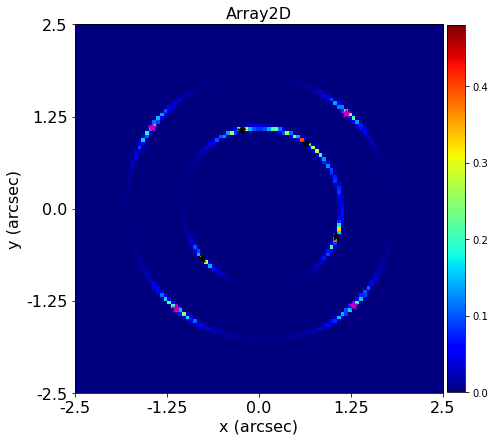

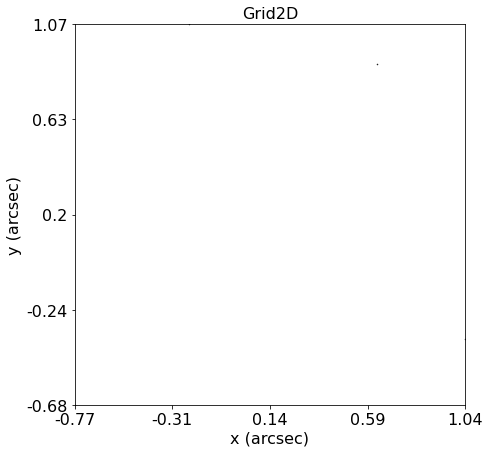

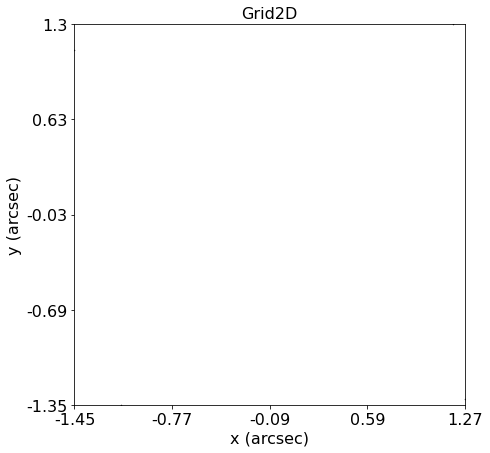

In [3]:
point_source_dict = al.PointSourceDict.from_json(
    file_path=path.join(dataset_path, "point_source_dict.json")
)

print("Point Source Multiple Image (y,x) Arc-second Coordinates:")
print(point_source_dict["point_0"].positions.in_list)
print(point_source_dict["point_1"].positions.in_list)

visuals_2d = aplt.Visuals2D(positions=point_source_dict.positions_list)

array_plotter = aplt.Array2DPlotter(array=image, visuals_2d=visuals_2d)
array_plotter.figure_2d()

grid_plotter = aplt.Grid2DPlotter(grid=point_source_dict["point_0"].positions)
grid_plotter.figure_2d()
grid_plotter = aplt.Grid2DPlotter(grid=point_source_dict["point_1"].positions)
grid_plotter.figure_2d()

__Paths__

The path the results of all chained searches are output:

In [4]:
path_prefix = path.join("point_source", "chaining", "single_plane_to_double_plane")

__PositionsSolver__

Setup the `PositionSolver`.

In [5]:
grid = al.Grid2D.uniform(
    shape_native=image.shape_native, pixel_scales=image.pixel_scales
)

positions_solver = al.PositionsSolver(grid=grid, pixel_scale_precision=0.025)

__Model (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` [5 parameters].
 - The intermediate source galaxy is a point `PointSource` [2 parameters].
 - The second source galaxy is included, so its redshift is used to perform multi-plane ray-tracing, but no model
 components are included [0 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=9.

In [6]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal)
source_0 = af.Model(al.Galaxy, redshift=1.0, point_0=al.ps.PointSource)
source_1 = af.Model(al.Galaxy, redshift=2.0)

model = af.Collection(
    galaxies=af.Collection(lens=lens, source_0=source_0, source_1=source_1)
)

__Search + Analysis + Model-Fit (Search 1)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the results of the search 1 model-fit to ensure a fast non-linear search has been provided that 
provides a reasonably accurate lens model.

In [7]:
search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[1]__single_plane",
    unique_tag=dataset_name,
    nlive=50,
)

analysis = al.AnalysisPointSource(
    point_source_dict=point_source_dict, solver=positions_solver
)

result_1 = search.fit(model=model, analysis=analysis)

2021-05-10 15:49:52,454 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  2.03it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < -552.664 <    inf | logz: -557.328 +/-    nan | dlogz:  1.099 >  0.059]
2021-05-10 15:49:53,458 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:49:53,541 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:49:53,610 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` [5 parameters: priors initialized from search 1].
 - The intermediate source galaxy's emission is again a point `PointSource` [2 parameters: priors initialized from 
 search 1].
 - The intermediate source galaxy's total mass distribution is also modeled as an `EllIsothermal` [5 parameters].
 - The second source galaxy is modeling using a point `PointSource` [2 parameters: no prior initialization].
 
The number of free parameters and therefore the dimensionality of non-linear parameter space is N=14.

The term `model` below passes the source model as model-components that are to be fitted for by the  non-linear search. 
Because the source model does not change we can pass its priors by simply using the`model` attribute of the result:

In [8]:
lens = result_1.model.galaxies.lens
source_0 = af.Model(
    al.Galaxy,
    redshift=1.0,
    mass=al.mp.EllIsothermal,
    point_0=result_1.model.galaxies.source_0.point_0,
)

source_1 = af.Model(al.Galaxy, redshift=2.0, point_1=al.ps.PointSource)


model = af.Collection(
    galaxies=af.Collection(lens=lens, source_0=source_0, source_1=source_1)
)

__Search + Analysis + Model-Fit (Search 2)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the `model.info` file of the search 2 model-fit to ensure the priors were passed correctly, as 
well as the checkout the results to ensure an accurate power-law mass model is inferred.

In [9]:
search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[2]__double_plane",
    unique_tag=dataset_name,
    nlive=75,
)

analysis = al.AnalysisPointSource(
    point_source_dict=point_source_dict, solver=positions_solver
)

result_2 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
2021-05-10 15:49:54,029 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 23.24it/s, +75 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 100.000 | loglstar:   -inf < -1797.829 <    inf | logz: -1802.880 +/-    nan | dlogz:  1.099 >  0.084]
2021-05-10 15:49:54,134 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:49:54,326 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:49:54,499 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__Wrap Up__

In this example, we passed used prior passing to initialize a model fit to the first plane in a double plane system 
and passed its priors to then fit a model to the full double plane system.

This allowed us to fit the first plane in a fast and efficient manner, before moving on to fit the whole system.